In [1]:
import pandas as pd
import numpy as np
from dgutils.pandas import add_column

/Users/alicegao/anaconda2/envs/yeast_d_cell/lib/python3.7/site-packages/genome_kit/data_manager.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
sns.set(color_codes=True)
import cufflinks as cf
cf.go_offline()
cf.set_config_file(theme='ggplot')

/Users/alicegao/anaconda2/envs/yeast_d_cell/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/alicegao/anaconda2/envs/yeast_d_cell/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/alicegao/anaconda2/envs/yeast_d_cell/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
from scipy.stats import pearsonr

In [5]:
from torch.utils.data import Dataset, DataLoader

In [6]:
df_raw = pd.read_csv('data/for_comparison/SGA_ExE.txt', 
                     sep='\t')[['Query Strain ID', 'Array Strain ID', 
                                'Query single mutant fitness (SMF)', 'Array SMF',
                                'Double mutant fitness']].rename(columns={
    'Query Strain ID': 's1',
    'Array Strain ID': 's2',
    'Query single mutant fitness (SMF)': 'f1',
    'Array SMF': 'f2',
    'Double mutant fitness': 'fitness',
})

def _get_gene_id(strain_id):
    gene_id, _ = strain_id.split('_')
    return gene_id


df_raw = add_column(df_raw, 'g1', ['s1'], _get_gene_id)
df_raw = add_column(df_raw, 'g2', ['s2'], _get_gene_id)

# df_tr = pd.read_csv('data/training/GO:0006281_training_data_2016_0', 
#                     header=None, names=['foo', 'g1', 'g2', 'fitness'], sep=' ')
# df_ts = pd.read_csv('data/training/GO_0006281_testing_data_2016_0.txt', 
#                     header=None, names=['foo', 'g1', 'g2', 'fitness'], sep=' ')

In [7]:
len(df_raw)

818570

In [8]:
len(df_raw[['g1', 'g2']].drop_duplicates())

418821

In [9]:
df_raw = df_raw[['g1', 'g2', 'fitness']].groupby(by=['g1', 'g2'], as_index=False).agg('median')
# TODO merge in f1 and f2

In [10]:
df_raw.head()

,g1,g2,fitness
0,YAL001C,YBL023C,0.7319
1,YAL001C,YBL026W,0.4266
2,YAL001C,YBL034C,0.6661
3,YAL001C,YBL035C,0.4715
4,YAL001C,YBL040C,0.6036


In [11]:
# shuffle rows
df_raw = df_raw.sample(frac=1).reset_index(drop=True)
# subset
_n_tr = int(len(df_raw)*0.8)
print(_n_tr)
df_tr = df_raw[:_n_tr]
df_ts = df_raw[_n_tr:]
# make sure genes are the same (for now drop rows that are not)
genes_tr = set(df_tr.g1.unique().tolist() + df_tr.g2.unique().tolist())
genes_ts = set(df_ts.g1.unique().tolist() + df_ts.g2.unique().tolist())
genes_intersection = genes_tr.intersection(genes_ts)
print(len(genes_tr), len(genes_ts), len(genes_intersection))
df_tr = df_tr[df_tr['g1'].isin(genes_intersection)]
df_tr = df_tr[df_tr['g2'].isin(genes_intersection)]
df_ts = df_ts[df_ts['g1'].isin(genes_intersection)]
df_ts = df_ts[df_ts['g2'].isin(genes_intersection)]
print(len(df_tr), len(df_ts))

335056
855 855 855
335056 83765


In [12]:
# # FIXME for now use all data
# # later on subset to tr and ts (make sure both have all genes?)
# df_tr = df_raw.copy()
# gene_ids = tuple(set(df_raw.g1.tolist() + df_raw.g2.tolist()))
# num_genes = len(gene_ids)

In [13]:
# encode data
# gene_ids = tuple(genes_tr)  # use this to assign a unique index for each gene
# num_genes = len(gene_ids)

gene_ids = tuple(genes_intersection)
num_genes = len(gene_ids)


def encode_x(g1, g2, l, gene_ids):
    x = np.ones(l)
    x[gene_ids.index(g1)] = 0
    x[gene_ids.index(g2)] = 0
    return x


df_tr = add_column(df_tr, 'x', ['g1', 'g2'], lambda g1, g2: encode_x(g1, g2, num_genes, gene_ids))
df_ts = add_column(df_ts, 'x', ['g1', 'g2'], lambda g1, g2: encode_x(g1, g2, num_genes, gene_ids))


In [14]:
# get data
x_tr = np.asarray(df_tr['x'].to_list())
y_tr = np.asarray(df_tr['fitness'].to_list())
x_ts = np.asarray(df_ts['x'].to_list())
y_ts = np.asarray(df_ts['fitness'].to_list())
print(x_tr.shape, y_tr.shape, x_ts.shape, y_ts.shape)
assert x_tr.shape[0] == y_tr.shape[0]
assert x_ts.shape[0] == y_ts.shape[0]
# print(x_tr.shape, y_tr.shape)

(335056, 855) (335056,) (83765, 855) (83765,)


In [15]:
# TODO data pre-preoceesing, y log transformation?

In [16]:
# dataset
class MyDataSet(Dataset):

    def __init__(self, x, y):
        assert x.shape[0] == y.shape[0]
        self.len = x.shape[0]
        self.x = x
        # add new axis if needed
        if len(y.shape) == 1:
            self.y = y[:, np.newaxis]
        else:
            self.y = y

    def __getitem__(self, index):
#         return self.x[index, :], self.y[index]
        return torch.from_numpy(self.x[index, :]).float(), torch.from_numpy(self.y[index]).float()

    def __len__(self):
        return self.len

In [17]:
# # a fully connected net
# class Net(nn.Module):

#     def __init__(self, n_in):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(n_in, 10)
#         self.fc2 = nn.Linear(10, 1)

#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x

In [18]:
model = torch.nn.Sequential(
    torch.nn.Linear(num_genes, 20),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(20),
    torch.nn.Linear(20, 10),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(10),
    torch.nn.Linear(10, 5),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(5),
    torch.nn.Linear(5, 1),
)

# model = torch.nn.Sequential(
#     torch.nn.Linear(num_genes, 50),
#     torch.nn.ReLU(),
#     torch.nn.Linear(50, 1),
# )


In [19]:
data_tr_loader = DataLoader(dataset=MyDataSet(x_tr, y_tr),
                         batch_size=200, shuffle=True)
data_ts_loader = DataLoader(dataset=MyDataSet(x_ts, y_ts),
                         batch_size=1000, shuffle=True)

In [20]:
# net = Net(num_genes)
# print(net)

In [21]:
loss_fn = torch.nn.MSELoss(reduction='mean')

In [22]:
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [23]:
device = torch.device("cpu")

In [24]:
# net_input = torch.randn(1, 1, 32, 32)
# net_output = net(net_input)
# target = torch.randn(10)  # a dummy target, for example
# target = target.view(1, -1)  # make it the same shape as output
# criterion = nn.MSELoss()

# loss = criterion(output, target)

In [25]:
# # inital test performance
# with torch.set_grad_enabled(False):
#     for xt, yt in data_ts_loader:
#         yt_pred = model(xt)
#         loss = loss_fn(yt_pred, yt)
#         print('initial test: ', loss.item())
            
for epoch in range(50):
    # Training
    for x_batch, y_batch in data_tr_loader:
        y_batch_pred = model(x_batch)
        loss = loss_fn(y_batch_pred, y_batch)
#         print(loss.item())
        model.zero_grad()
        loss.backward()
        optimizer.step()
    # just print the last one for debugging
    print(loss.item())
    
    # test
    with torch.set_grad_enabled(False):
#         for xt, yt in data_ts_loader:
#             yt_pred = model(xt)
#             loss = loss_fn(yt_pred, yt)
#             print('test: ', loss.item())
        # using the first batch for now - this probably shuffles?
        for xt, yt in data_ts_loader:
#         xt, yt = data_ts_loader[0]
            yt_pred = model(xt)
            loss = loss_fn(yt_pred, yt)
            print('test: ', loss.item())
            break

0.12660500407218933
test:  0.10254660248756409
0.01827419176697731
test:  0.011689945124089718
0.012162568978965282
test:  0.009209245443344116
0.007521900348365307
test:  0.008459134958684444
0.01802689954638481
test:  0.007901884615421295
0.007945054210722446
test:  0.008646844886243343
0.0057324692606925964
test:  0.008103911764919758
0.009103002026677132
test:  0.00705969100818038
0.007744746748358011
test:  0.008626988157629967
0.0045531392097473145
test:  0.007936215959489346
0.010128764435648918
test:  0.006643206812441349
0.0072647640481591225
test:  0.007241649087518454
0.006579577457159758
test:  0.006418229080736637
0.008891371078789234
test:  0.00853270199149847
0.0093677444383502
test:  0.007818196900188923
0.015886101871728897
test:  0.007931433618068695
0.0040473854169249535
test:  0.008513104170560837
0.0054941801354289055
test:  0.008878881111741066
0.00609562499448657
test:  0.006523808930069208
0.007434902247041464
test:  0.008944330736994743
0.0072113764472305775
te

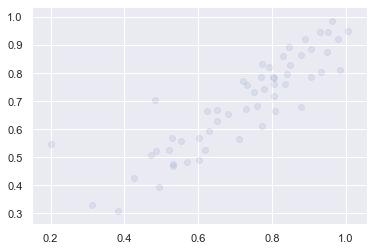

In [26]:
# training mini batch
plt.scatter(y_batch.detach().numpy(), y_batch_pred.detach().numpy(), alpha=0.1)

In [27]:
print(pearsonr(y_batch.detach().numpy(), y_batch_pred.detach().numpy()))

(array([0.88218486], dtype=float32), array([2.6564404e-19], dtype=float32))


In [28]:
# test (larger mini batch)

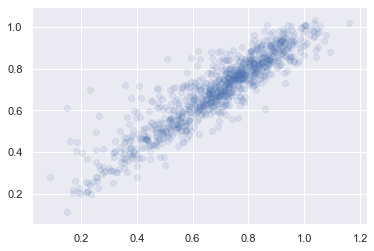

In [29]:
plt.scatter(yt, yt_pred, alpha=0.1)

In [30]:
print(pearsonr(yt, yt_pred.numpy()))

(array([0.91477287], dtype=float32), array([0.], dtype=float32))
